# Setup, matplotlib inline, automatically reload libraries on every evaluation

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [30]:
from epiml.loadepiml import LoadEpiml, load_search, save_search
from epiml.epimlsklearn.epimlmetrics import pu_scorer, prior_squared_error_scorer_015, brier_score_labeled_loss_scorer, \
    f1_assumed_scorer, f1_labeled_scorer, report_metrics, f1_assumed_beta10_scorer, pu_mix_assumed_f1beta10_scorer
from epiml.semisuperhelper import SemiSupervisedHelper
from epiml.epimlsklearn.pnuwrapper import PNUWrapper
from epiml.epimlsklearn.jsearchcv import JRandomSearchCV, extract_score_grid
from epiml.epimlsklearn.nestedcross import NestedCV, rerun_nested_for_scoring
from epiml.epimlsklearn.frankenscorer import FrankenScorer, extract_scores_from_nested
from epiml.epimlsklearn.repeatedsampling import RepeatedRandomSubSampler

In [6]:
path = "C:\\Data\\010317\\membership14_final_0103.txt"
lc = LoadEpiml(path)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone

In [8]:
X_train, X_test, y_train, y_test = train_test_split(lc.X, lc.y, test_size=0.2, random_state=771, stratify=lc.y)

# REPEATED SUB SAMPLER

## Set up PNU Wrapper with Random Forest, then JSearchCV, then NestedCV

In [123]:
rf = RandomForestClassifier()
rep = RepeatedRandomSubSampler(base_estimator=rf, voting='thresh', verbose=1, random_state=83)
pnu = PNUWrapper(base_estimator=rep, num_unlabeled=1.0)

## Set up randomized search parameters

In [10]:
rf_param_search = {'base_estimator__base_estimator__bootstrap': [True, False],
 'base_estimator__base_estimator__class_weight': [None,'balanced','balanced_subsample'],
 'base_estimator__base_estimator__criterion': ['gini','entropy'],
 'base_estimator__base_estimator__max_depth': [None] + list(range(2,100)),
 'base_estimator__base_estimator__max_features': ['sqrt','log2',None] + list(range(5,100)),
 'base_estimator__base_estimator__min_samples_leaf': [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100],
 'base_estimator__base_estimator__min_samples_split':[2,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,
                                                        0.045,0.05,0.07,0.09,0.1,0.12,0.15,0.17,0.2,0.25],
 'base_estimator__base_estimator__n_estimators': sp.stats.randint(low=10, high=300),
 'base_estimator__sample_imbalance': sp.stats.uniform(loc=0.1, scale=0.9),
 'pu_learning': [True, False]
                  }

### notice random_state is set in jsearch, this is so that the same random parameters are searched for each outer fold, sort of like grid search

In [11]:
jsearch = JRandomSearchCV(pnu, rf_param_search, n_iter=60, scoring=FrankenScorer(decision_score='assumed_f1beta10'),
                                n_jobs=-1, cv=3, verbose=1, pre_dispatch=8, random_state=77)

#### 3x3 (x60) nested cross validation

In [12]:
nested_cross = NestedCV(jsearch, scoring=FrankenScorer(decision_score='pu_mix_assumed_f1beta10'), cv=3, random_state=77)

## Score the nested cross

In [13]:
scores = nested_cross.score(X_train.values, y=y_train.values, verbose=100, pre_dispatch=8)

[CV]  ................................................................
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 285.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 1339.8min finished


generating 74 samples of indices to use to train multiple estimators, sized 4299 elements with last being 1884 elements


[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:  6.7min finished
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:  5.4min finished
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:  5.4min finished
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed: 11.3min finished
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed: 11.3min finished


[CV]  , score=0.72386509585 score_data={'pr_one_unlabeled': 0.058881508463681169, 'pu_score': 10.504795256161353, 'labeled_avg_prec': 0.92260361057274554, 'assumed_f1': 0.11408379606259465, 'assumed_brier': 0.055929870476330655, 'labeled_roc_auc': 0.82762006283662481, 'labeled_recall': 0.81149012567324952, 'assumed_f1beta10': 0.72386509585044467, 'labeled_brier_neg': 0.15226353887671454, 'SCORE': 0.72386509585044467, 'pu_mix_assumed_f1beta10': 82.891304841205823, 'labeled_prec': 0.9094567404426559, 'labeled_brier_pos': 0.18399826630454028, 'assumed_brier_neg': 0.055319984474122161, 'confusion_matrix_lab': array([[243,  45],
       [105, 452]]), 'confusion_matrix_un': array([[110048,   6915],
       [   105,    452]]), 'labeled_brier': 0.17318216985576651, 'labeled_f1': 0.85768500948766602, 'labeled_acc': 0.8224852071005917}, total=1357.4min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 1380.0min remaining:    0.0s
[CV]  ...........................................................

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 284.9min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 1343.3min finished


generating 74 samples of indices to use to train multiple estimators, sized 4299 elements with last being 1884 elements


[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:  7.1min finished
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:  5.5min finished
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:  5.5min finished
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed: 11.5min finished
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed: 11.5min finished


[CV]  , score=0.71242539338 score_data={'pr_one_unlabeled': 0.055556031712020573, 'pu_score': 10.629386934525813, 'labeled_avg_prec': 0.92531303090637329, 'assumed_f1': 0.11756882564170767, 'assumed_brier': 0.053152132849711362, 'labeled_roc_auc': 0.83056631156206406, 'labeled_recall': 0.79353680430879714, 'assumed_f1beta10': 0.71242539338035804, 'labeled_brier_neg': 0.13052903642883867, 'SCORE': 0.71242539338035804, 'pu_mix_assumed_f1beta10': 81.871926272561609, 'labeled_prec': 0.92083333333333328, 'labeled_brier_pos': 0.20274171740764008, 'assumed_brier_neg': 0.052439752772431868, 'confusion_matrix_lab': array([[249,  38],
       [115, 442]]), 'confusion_matrix_un': array([[110442,   6520],
       [   115,    442]]), 'labeled_brier': 0.17818598347290548, 'labeled_f1': 0.85245901639344257, 'labeled_acc': 0.81872037914691942}, total=1361.5min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 2764.6min remaining:    0.0s
[CV]  .........................................................

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 289.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 1354.8min finished


generating 156 samples of indices to use to train multiple estimators, sized 2621 elements with last being 1454 elements


[Parallel(n_jobs=1)]: Done 156 out of 156 | elapsed:  6.6min finished
[Parallel(n_jobs=1)]: Done 156 out of 156 | elapsed:  7.1min finished
[Parallel(n_jobs=1)]: Done 156 out of 156 | elapsed:  7.1min finished
[Parallel(n_jobs=1)]: Done 156 out of 156 | elapsed: 14.8min finished
[Parallel(n_jobs=1)]: Done 156 out of 156 | elapsed: 14.8min finished


[CV]  , score=0.716921316343 score_data={'pr_one_unlabeled': 0.073383958722594581, 'pu_score': 8.8360179044611566, 'labeled_avg_prec': 0.92747372050325882, 'assumed_f1': 0.095426195426195431, 'assumed_brier': 0.068176802579018383, 'labeled_roc_auc': 0.8378568921865992, 'labeled_recall': 0.82553956834532372, 'assumed_f1beta10': 0.71692131634294198, 'labeled_brier_neg': 0.13625345625814669, 'SCORE': 0.71692131634294198, 'pu_mix_assumed_f1beta10': 80.528149538755358, 'labeled_prec': 0.91434262948207168, 'labeled_brier_pos': 0.16248059244911764, 'assumed_brier_neg': 0.067728508641998544, 'confusion_matrix_lab': array([[244,  43],
       [ 97, 459]]), 'confusion_matrix_un': array([[108356,   8605],
       [    97,    459]]), 'labeled_brier': 0.15355154371031732, 'labeled_f1': 0.86767485822306234, 'labeled_acc': 0.83392645314353497}, total=1375.6min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 4169.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 4169.9min

In [15]:
save_search(nested_cross, './res/nested_cross_repreated_rf_large_20170131.pkl')

In [15]:
nested_cross = load_search('./res/nested_cross_repreated_rf_large_20170131.pkl')

In [35]:
extract_scores_from_nested(nested_cross.test_score_datas_).mean().sort_index()

assumed_brier                                                      0.0537134
assumed_brier_neg                                                  0.0530405
assumed_f1                                                          0.117128
assumed_f1beta10                                                    0.716654
confusion_matrix_lab       [[249.666666667, 37.6666666667], [111.66666666...
confusion_matrix_un        [[110360.333333, 6601.66666667], [111.66666666...
fn_confusion_matrix_lab                                              111.667
fn_confusion_matrix_un                                               111.667
fp_confusion_matrix_lab                                              37.6667
fp_confusion_matrix_un                                               6601.67
labeled_acc                                                         0.823067
labeled_avg_prec                                                    0.926954
labeled_brier                                                       0.172289

In [36]:
nested_cross.best_idxs_

[51.0, 51.0, 51.0]

In [37]:
nested_cross.best_params_

[{'base_estimator__base_estimator__bootstrap': False,
  'base_estimator__base_estimator__class_weight': None,
  'base_estimator__base_estimator__criterion': 'gini',
  'base_estimator__base_estimator__max_depth': 47,
  'base_estimator__base_estimator__max_features': 49,
  'base_estimator__base_estimator__min_samples_leaf': 6,
  'base_estimator__base_estimator__min_samples_split': 0.02,
  'base_estimator__base_estimator__n_estimators': 177,
  'base_estimator__sample_imbalance': 0.34927465901033783,
  'pu_learning': True},
 {'base_estimator__base_estimator__bootstrap': False,
  'base_estimator__base_estimator__class_weight': None,
  'base_estimator__base_estimator__criterion': 'gini',
  'base_estimator__base_estimator__max_depth': 47,
  'base_estimator__base_estimator__max_features': 49,
  'base_estimator__base_estimator__min_samples_leaf': 6,
  'base_estimator__base_estimator__min_samples_split': 0.02,
  'base_estimator__base_estimator__n_estimators': 177,
  'base_estimator__sample_imbal

# Now that we have comparable, nested search scores, lets do a search on the whole 80% training set and use the parameters found

In [50]:
jsearch_train = JRandomSearchCV(pnu, rf_param_search, n_iter=60, scoring=FrankenScorer(decision_score='pu_mix_assumed_f1beta10'),
                                n_jobs=-1, cv=3, verbose=1, pre_dispatch=8, random_state=77)

In [52]:
jsearch_fit = jsearch_train.fit(X_train.values, y_train.values)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 441.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 2076.2min finished


generating 156 samples of indices to use to train multiple estimators, sized 3930 elements with last being 2256 elements


[Parallel(n_jobs=1)]: Done 156 out of 156 | elapsed: 10.0min finished


In [53]:
save_search(jsearch_fit, './res/jsearch_only.pkl')

In [60]:
jsearch_score_grid = extract_score_grid(jsearch_fit)

In [124]:
best_idx = jsearch_score_grid.mean_pu_mix_assumed_f1beta10_test.idxmax()

In [125]:
model6_params = pd.DataFrame(jsearch_fit.cv_results_).params[best_idx]

In [126]:
model6_params

{'base_estimator__base_estimator__bootstrap': False,
 'base_estimator__base_estimator__class_weight': None,
 'base_estimator__base_estimator__criterion': 'gini',
 'base_estimator__base_estimator__max_depth': 47,
 'base_estimator__base_estimator__max_features': 49,
 'base_estimator__base_estimator__min_samples_leaf': 6,
 'base_estimator__base_estimator__min_samples_split': 0.02,
 'base_estimator__base_estimator__n_estimators': 177,
 'base_estimator__sample_imbalance': 0.34927465901033783,
 'pu_learning': True}

## This is model 6 in draft, lets retrain on whole training set and then test on 20% test set!

In [67]:
pnu_test = clone(pnu)
pnu_test.set_params(**model6_params)

PNUWrapper(base_estimator=RepeatedRandomSubSampler(base_estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=47, max_features=49, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=6,
            min_samples_split=0.02, min_weight...     random_state=None, sample_imbalance=0.34927465901033783,
             verbose=1, voting='hard'),
      num_unlabeled=1.0, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [68]:
pnu_test.fit(X_train.values, y_train.values)

generating 74 samples of indices to use to train multiple estimators, sized 6451 elements with last being 2681 elements


[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed: 11.2min finished


PNUWrapper(base_estimator=RepeatedRandomSubSampler(base_estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=47, max_features=49, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=6,
            min_samples_split=0.02, min_weight...     random_state=None, sample_imbalance=0.34927465901033783,
             verbose=1, voting='hard'),
      num_unlabeled=1.0, pu_learning=True, random_state=None,
      threshold_set_pct=None)

In [71]:
FrankenScorer()(pnu_test, X_test.values, y_test.values)

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:  3.6min finished


({'SCORE': 0.85350318471337572,
  'assumed_brier': 0.042549880360963133,
  'assumed_brier_neg': 0.041951697918468568,
  'assumed_f1': 0.11764705882352941,
  'assumed_f1beta10': 0.71871614588865051,
  'confusion_matrix_lab': array([[183,  32],
         [ 83, 335]]),
  'confusion_matrix_un': array([[82780,  4942],
         [   83,   335]]),
  'labeled_acc': 0.81832543443917849,
  'labeled_avg_prec': 0.92268179458904287,
  'labeled_brier': 0.14822197745650947,
  'labeled_brier_neg': 0.10960419310967416,
  'labeled_brier_pos': 0.16808519189327886,
  'labeled_f1': 0.85350318471337572,
  'labeled_prec': 0.91280653950953683,
  'labeled_recall': 0.80143540669856461,
  'labeled_roc_auc': 0.82629909869811957,
  'pr_one_unlabeled': 0.056109796930531274,
  'pu_mix_assumed_f1beta10': 82.599719269032505,
  'pu_score': 10.728104680167453},
 0.85350318471337572)

# Feature importance for 80/20

In [72]:
importance = pd.DataFrame(pnu_test.feature_importances_, index=X_test.columns.values, columns=['Importance']).sort_values(by='Importance', ascending=False)
importance.round(5) * 100

,Importance
DIAG_FLAG4_Sum,39.058
DIAG_FLAG5_Sum,24.451
ndc_cat58_Sum,5.401
CPT_FLAG9_Sum,3.601
ndc_cat87_Sum,3.243
DIAG_FLAG75_Sum,2.538
ndc_cat54_Sum,1.150
age,1.058
CPT_FLAG43_Sum,0.986
DIAG_FLAG42_Sum,0.843


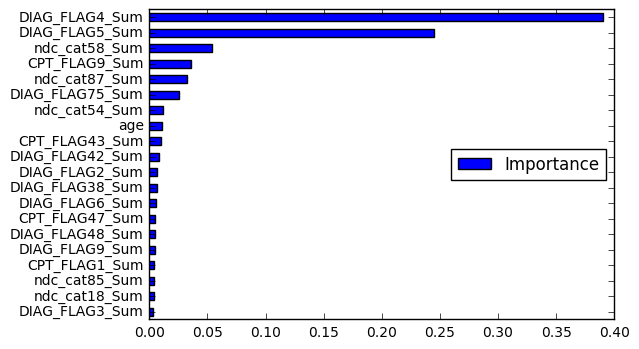

In [74]:
ax = importance.iloc[:20].iloc[::-1].plot(kind='barh')
ax.legend(loc='right')

# Probability distribution of the 20%

In [107]:
def generate_probability_table(clf, X_test, y_test):
    probas = clf.predict_proba(X_test)[:, -1]
    probas_df = pd.DataFrame(data={'probas':probas, 'y_test':y_test.values}).sort_values(by='probas', ascending=False)
    bins = np.linspace(0.0, 1.0, 101)
    percent = pd.cut(probas_df['probas'], bins=bins, include_lowest=True, precision=6, labels=list(range(0,100)))
    probas_df['percent'] = percent
    dummies = pd.get_dummies(probas_df['y_test'], prefix='y=', prefix_sep='')
    probas_df = pd.concat([probas_df, dummies], axis=1)
    probas_group = probas_df.groupby('percent')
    percentile_df = probas_group.aggregate({'probas':'count', 'y=-1':'sum', 'y=0':'sum', 'y=1':'sum'})
    labeled_tot = percentile_df['y=1'] + percentile_df['y=0']
    percentile_df['unlabeled_pct'] = percentile_df['y=-1'] / percentile_df.probas
    percentile_df['true_pos_pct'] = percentile_df['y=1'] / labeled_tot
    percentile_df['true_neg_pct'] = percentile_df['y=0'] / labeled_tot
    tot = percentile_df.probas.sum()
    percentile_df['pct_of_total'] = percentile_df.probas / tot
    percentile_df['cum_pct_of_total'] = percentile_df.pct_of_total.cumsum()
    percentile_df = percentile_df.ffill()
    percentile_df = percentile_df.reset_index()
    tp = np.polyfit(x=percentile_df.index.values.astype(int), y=percentile_df.true_pos_pct, deg=1)
    tpp = np.poly1d(tp)
    percentile_df['tp_trendline'] = tpp(percentile_df.index.values.astype(int))
    tn = np.polyfit(x=percentile_df.index.values.astype(int), y=percentile_df.true_neg_pct, deg=1)
    tnp = np.poly1d(tn)
    percentile_df['tn_trendline'] = tnp(percentile_df.index.values.astype(int))
    return probas_df, percentile_df

In [108]:
probas_df, percentile_df = generate_probability_table(pnu_test, X_test, y_test)

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:  3.7min finished


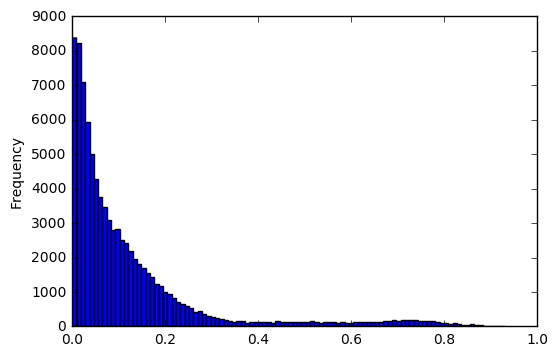

In [131]:
probas_df['probas'].plot.hist(bins=100)

In [132]:
probas_df.to_csv('./res/predicted_probabilities_soft.csv')

In [134]:
import matplotlib.pyplot as plt

In [135]:
df = percentile_df
x_axis = df.index.values.astype(int)

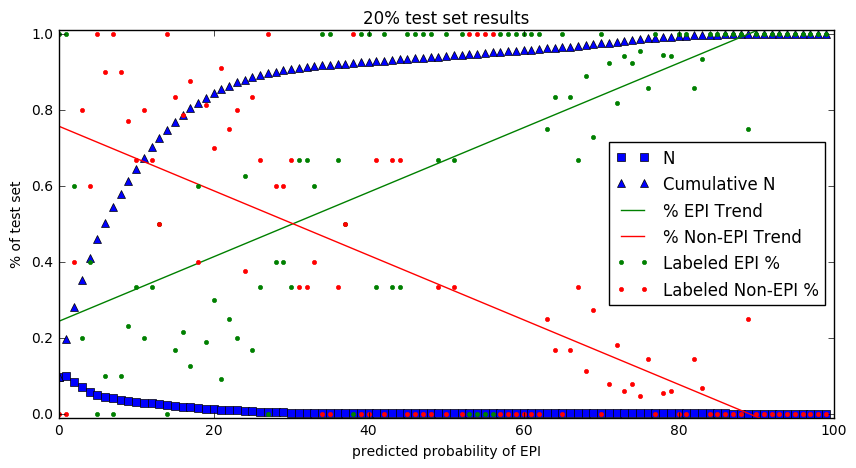

In [136]:
plt.figure(figsize=(10,5))
plt.plot(x_axis, df.pct_of_total, 'bs', label='N')
plt.plot(x_axis, df.cum_pct_of_total, 'b^', label='Cumulative N')
plt.plot(x_axis, df.tp_trendline, 'g-', label='% EPI Trend')
plt.plot(x_axis, df.tn_trendline, 'r-', label='% Non-EPI Trend')
plt.plot(x_axis, df.true_pos_pct, 'g.', label='Labeled EPI %')
plt.plot(x_axis, df.true_neg_pct, 'r.', label='Labeled Non-EPI %')
plt.axis([0, 100, -0.01, 1.01])
plt.ylabel('% of test set')
plt.xlabel('predicted probability of EPI')
plt.title('20% test set results')
plt.legend(loc='right')

# Precision Recall curve for various thresholds used for Model #6

In [137]:
from sklearn.metrics import precision_recall_curve

In [138]:
labeled_probas = probas_df[probas_df.y_test >= 0]

In [139]:
pr, re, th = precision_recall_curve(labeled_probas.y_test, labeled_probas.probas, pos_label=1)

In [141]:
# find pr of unlabeled == pos
unlabeled_probas = probas_df[probas_df.y_test == -1].probas.values
total_unlabeled = len(unlabeled_probas)
pr_one_un = []
for thresh in th:
    p = sum(unlabeled_probas >= thresh)
    pr_one_un.append(p / total_unlabeled)
pr_one_un.append(0.0)
pr_one_un = np.array(pr_one_un)

In [142]:
def find_re_pr_prob(thresh):
    idx = np.nonzero(th >= thresh)[0][0]
    return re[idx], pr[idx], pr_one_un[idx]

In [143]:
re_50, pr_50, _ = find_re_pr_prob(0.5)
re_35, pr_35, _ = find_re_pr_prob(0.35)
re_40, pr_40, _ = find_re_pr_prob(0.4)
re_80, pr_80, _ = find_re_pr_prob(0.8)
re_20, pr_20, _ = find_re_pr_prob(0.2)

In [144]:
from matplotlib import cm, colors, colorbar

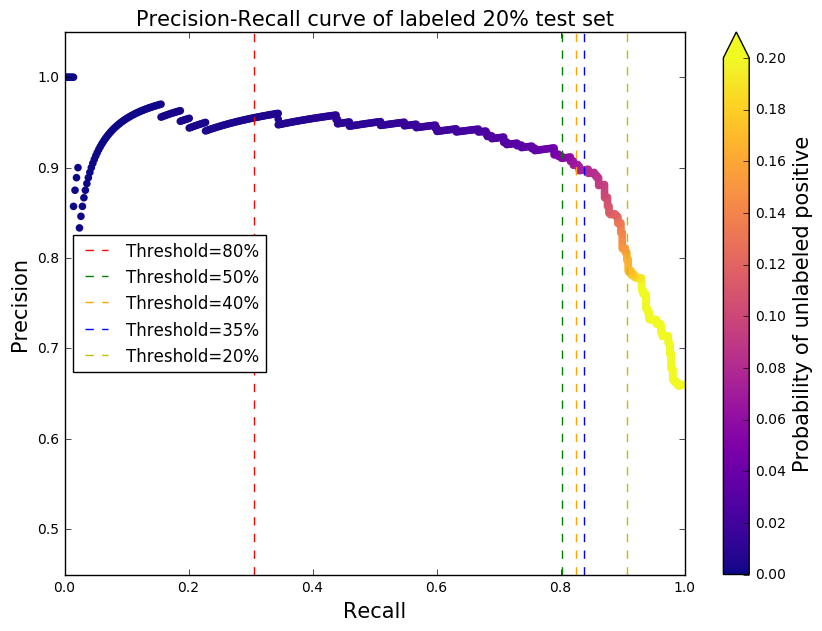

In [145]:
plt.clf()
plt.figure(figsize=(10, 7))
plt.xlabel('Recall', fontsize=15)
plt.xlim((0.0, 1.0))
plt.ylabel('Precision', fontsize=15)
plt.ylim((0.45, 1.05))
plt.title('Precision-Recall curve of labeled 20% test set', fontsize=15)
norm = colors.Normalize(vmin=0.0, vmax=0.2)
cmap = cm.plasma
plt.scatter(re, pr, c=pr_one_un, cmap=cmap, norm=norm, edgecolors='none', s=30)
#plt.scatter(re, pr, c=np.append(th, 1.0), cmap=cm.plasma, norm=norm)
cb = plt.colorbar(orientation='vertical', extend='max')
cb.set_label('Probability of unlabeled positive', fontsize=15)
plt.axvline(x=re_80, ls="--", c='r', label='Threshold=80%')
plt.axvline(x=re_50, ls="--", c='g', label='Threshold=50%')
plt.axvline(x=re_40, ls="--", c='orange', label='Threshold=40%')
plt.axvline(x=re_35, ls="--", c='b', label='Threshold=35%')
plt.axvline(x=re_20, ls="--", c='y', label='Threshold=20%')
plt.legend(loc='center left')
plt.show()